<a href="https://colab.research.google.com/github/bintangsholu21/Pembelajaran-Mesin/blob/main/Modul%2010%20-%20Recurrent%20Neural%20Network%20(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Job Sheet 10: Recurrent Neural Network (RNN)**

#### **Pembelajaran Mesin**

* Nama : Muhammad Bintang Sholu Firmansyah
* Kelas : TI - 3G
* NIM : 2141720101
* No Absen : 16

*Github Link https://github.com/bintangsholu21/Pembelajaran-Mesin*


---
## **Praktikum 1**

#### **RNN untuk Analisis Sentimen**

### **Setup**

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
 plt.plot(history.history['val_'+metric], '')
 plt.plot(history.history[metric])
 plt.xlabel("Epochs")
 plt.ylabel(metric)
 plt.legend([metric, 'val_'+metric])

### **Setup input pipeline**

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan `TFDS`. Lihat `loading text tutorial` jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'Plot is not worth discussion even if it hints at corruption, murder, power and the rest of thriller related topics. Characters are interesting though sometimes. Not realistic but interesting nevertheless.<br /><br />Development is slow like tea drinking ceremony. Visuals not stunning, but good enough to ease the eye strain. Good movie to watch after dinner before going to bed - nothing shocking too much, nothing overexciting. Movie sitcom style.<br /><br />I liked Woody - excellent performance. Had to fight the plot inadequacy and did the job pretty good. The rest are bearable though very predictable. The whole is watchable and better than most TV shows.'
 b"Freddy's Dead: The Final Nightmare, the sixth installment of the Nightmare on Elm Street series and once again another bad sequel. I think this is tied up with the last sequel of the Dream Child. I was lucky enough to get the Nightmare on Elm Street series box DVD set for my birthday, so I got to see all the sequels. May

### **Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [ ]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [ ]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[114,   7,  22, ...,   0,   0,   0],
       [  1, 358,   2, ...,   0,   0,   0],
       [459,  48,  14, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

* Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

* Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Plot is not worth discussion even if it hints at corruption, murder, power and the rest of thriller related topics. Characters are interesting though sometimes. Not realistic but interesting nevertheless.<br /><br />Development is slow like tea drinking ceremony. Visuals not stunning, but good enough to ease the eye strain. Good movie to watch after dinner before going to bed - nothing shocking too much, nothing overexciting. Movie sitcom style.<br /><br />I liked Woody - excellent performance. Had to fight the plot inadequacy and did the job pretty good. The rest are bearable though very predictable. The whole is watchable and better than most TV shows.'
Round-trip:  plot is not worth [UNK] even if it [UNK] at [UNK] murder power and the rest of thriller [UNK] [UNK] characters are interesting though sometimes not realistic but interesting [UNK] br development is slow like [UNK] [UNK] [UNK] [UNK] not [UNK] but good enough to [UNK] the eye [UNK] good movie to watch after [UN

### **Buat Model**

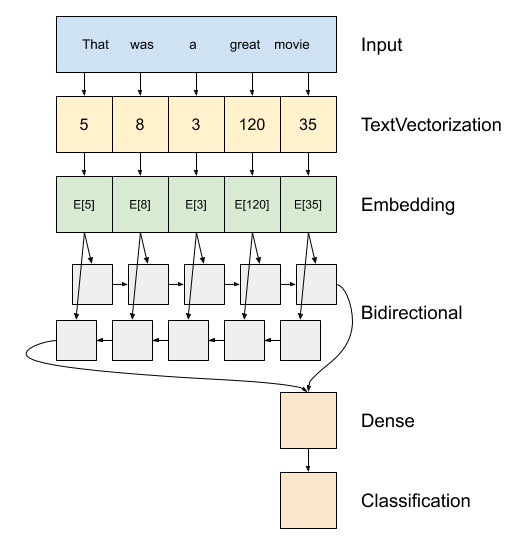

diagram model dapat dilihat pada gambar diatas
1. Model ini dapat dibuat sebagai tf.keras.Sequential.
2. Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
3. Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
4. Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.
  * Keuntungan utama RNN dua arah adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.
  * Kerugian utama dari RNN dua arah adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir.
5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

Kode nya adalah sebagai berikut :

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Harap dicatat bahwa model sekuensial Keras digunakan di sini karena semua lapisan dalam model hanya memiliki masukan tunggal dan menghasilkan keluaran tunggal. Jika Anda ingin menggunakan lapisan RNN stateful, Anda mungkin ingin membangun model Anda dengan API fungsional Keras atau subkelas model sehingga Anda dapat mengambil dan menggunakan kembali status lapisan RNN. Untuk detailnya bisa dilihat pada `Keras RNN guide`.

Lapisan penyematan menggunakan masking `(uses masking )` untuk menangani panjang urutan yang bervariasi. Semua lapisan setelah penyematan dukungan penyematan

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.00551749]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 1s 551ms/step
[0.00551749]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### **Train Model**

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)


Epoch 1/10
391/391 [==============================] - 615s 2s/step - loss: 0.6442 - accuracy: 0.5652 - val_loss: 0.4910 - val_accuracy: 0.7547
Epoch 2/10
391/391 [==============================] - 581s 1s/step - loss: 0.3996 - accuracy: 0.8166 - val_loss: 0.3656 - val_accuracy: 0.8422
Epoch 3/10
391/391 [==============================] - 604s 2s/step - loss: 0.3394 - accuracy: 0.8507 - val_loss: 0.3440 - val_accuracy: 0.8359
Epoch 4/10
391/391 [==============================] - 599s 2s/step - loss: 0.3215 - accuracy: 0.8588 - val_loss: 0.3303 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 583s 1s/step - loss: 0.3141 - accuracy: 0.8650 - val_loss: 0.3320 - val_accuracy: 0.8594
Epoch 6/10
391/391 [==============================] - 577s 1s/step - loss: 0.3088 - accuracy: 0.8667 - val_loss: 0.3268 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 574s 1s/step - loss: 0.3077 - accuracy: 0.8694 - val_loss: 0.3227 - val_accuracy: 0.8557

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 152s 390ms/step - loss: 0.3156 - accuracy: 0.8602
Test Loss: 0.3156089782714844
Test Accuracy: 0.8601599931716919


(0.0, 0.6614469870924949)

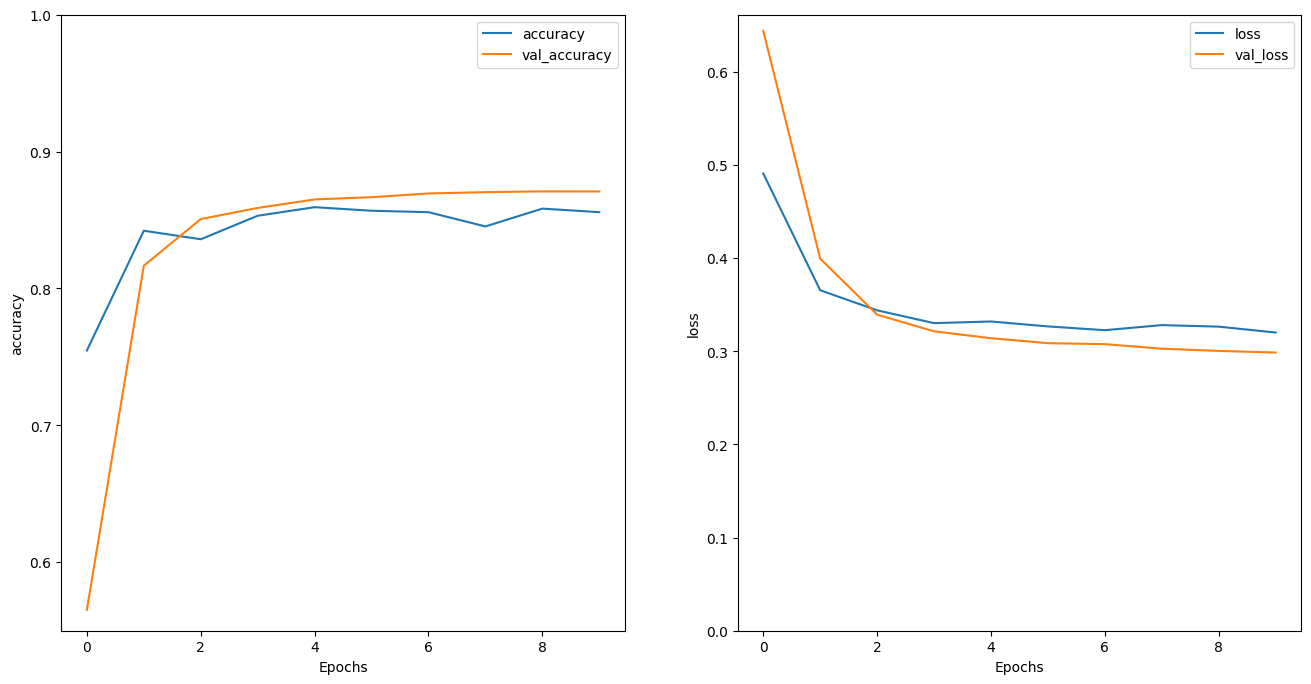

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:


Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Assuming 'model' is properly defined and compiled
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 4s 4s/step


### **Stack two or more LSTM layers**

Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :

* Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya.
* Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

Berikut adalah alur informasi dengan return_sequences=True:

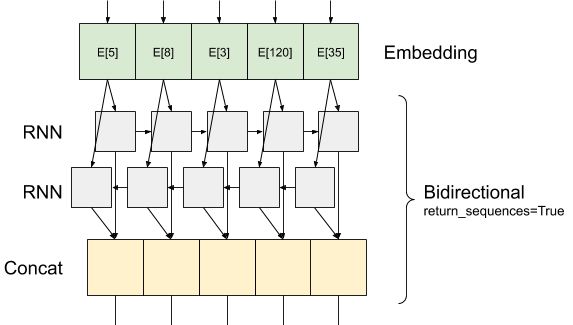

Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)


Epoch 1/10
391/391 [==============================] - 1201s 3s/step - loss: 0.6345 - accuracy: 0.5783 - val_loss: 0.4663 - val_accuracy: 0.7870
Epoch 2/10
391/391 [==============================] - 1182s 3s/step - loss: 0.3971 - accuracy: 0.8277 - val_loss: 0.3579 - val_accuracy: 0.8380
Epoch 3/10
391/391 [==============================] - 1205s 3s/step - loss: 0.3424 - accuracy: 0.8523 - val_loss: 0.3304 - val_accuracy: 0.8479
Epoch 4/10
391/391 [==============================] - 1181s 3s/step - loss: 0.3214 - accuracy: 0.8622 - val_loss: 0.3239 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 1145s 3s/step - loss: 0.3135 - accuracy: 0.8664 - val_loss: 0.3187 - val_accuracy: 0.8562
Epoch 6/10
391/391 [==============================] - 1156s 3s/step - loss: 0.3087 - accuracy: 0.8672 - val_loss: 0.3206 - val_accuracy: 0.8552
Epoch 7/10
391/391 [==============================] - 1147s 3s/step - loss: 0.3040 - accuracy: 0.8706 - val_loss: 0.3227 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 253s 648ms/step - loss: 0.3359 - accuracy: 0.8591
Test Loss: 0.33588907122612
Test Accuracy: 0.8590800166130066


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-2.0213764]]


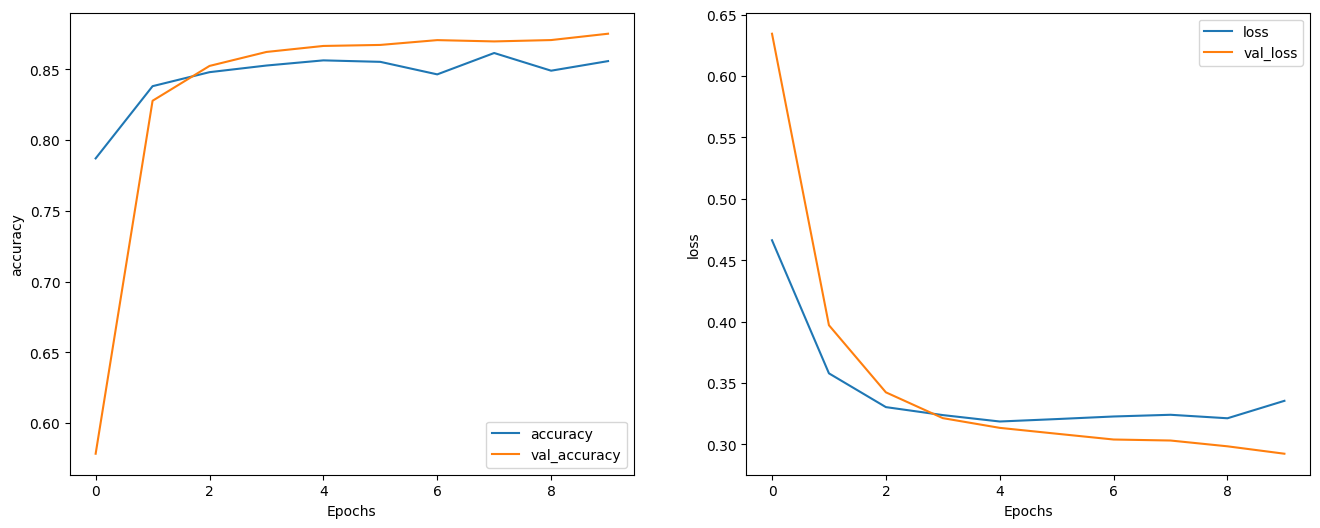

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

### **Catatan**

* Informasi menarik lain terkait dengan GRU layers.
* Informasi membuat custom RNN --> Keras RNN Guide.

---
## **Praktikum 2**

#### **Generator Teks dengan RNN**

Praktikum ini mendemonstrasikan cara melakukan genearsi text menggunakan RNN. Dataset yang digunkan adalah dataset Shakespeare's writing from Andrej Karpathy's `The Unreasonable Effectiveness of Recurrent Neural Networks`. Jika diberikan urutan karakter dari data ini ("Shakespear"), latih model untuk memprediksi karakter berikutnya dalam urutan ("e"). Urutan teks yang lebih panjang dapat dihasilkan dengan memanggil model berulang kali.

Note: Enable GPU acceleration to execute this notebook faster. In Colab: *Runtime > Change runtime type > Hardware accelerator > GPU.*

Tutorial ini menggunakan tf.keras dan eager execution. Berikut adalah contoh output ketika model dalam tutorial ini dilatih selama 30 epoch, dan dimulai dengan prompt "Q":


```
QUEENE:
I had thought thou hadst a Roman; for the oracle,
Thus by All bids the man against the word,
Which are so weak of care, by old care done;
Your children were in your holy love,
And the precipitation through the bleeding throne.

BISHOP OF ELY:
Marry, and will, my lord, to weep in such a one were prettiest;
Yet now I was adopted heir
Of the world's lamentable day,
To watch the next way with his father with his face?

ESCALUS:
The cause why then we are all resolved more sons.

VOLUMNIA:
O, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, no, it is no sin it should be dead,
And love and pale as any will to that word.

QUEEN ELIZABETH:
But how long have I heard the soul for this world,
And show his hands of life be proved to stand.

PETRUCHIO:
I say he look'd on, if I must be content
To stay him from the fatal of our country's bliss.
His lordship pluck'd from this sentence then for prey,
And then let us twain, being the moon,
were she such a case as fills m
```

Meskipun beberapa kalimat memiliki tata bahasa, sebagian besar tidak masuk akal. Model belum mempelajari arti kata-kata, namun anggap saja:

* Modelnya berbasis karakter. Saat pelatihan dimulai, model tidak mengetahui cara mengeja kata dalam bahasa Inggris, atau bahkan kata-kata tersebut merupakan satuan teks.
* Struktur keluarannya menyerupai sandiwara—blok teks umumnya dimulai dengan nama pembicara, dengan huruf kapital semua mirip dengan kumpulan data.
* Seperti yang ditunjukkan di bawah, model dilatih pada kumpulan teks kecil (masing-masing 100 karakter), dan masih mampu menghasilkan rangkaian teks yang lebih panjang dengan struktur yang koheren.

### **Setup**

**Import TensorFlow**

In [1]:
import tensorflow as tf
import numpy as np
import os
import time

**Download Dataset Shakespeare**

Sesuaikan dengan lokasi data yang Anda punya.

In [2]:
path_to_file=tf.keras.utils.get_file('shakespeare.txt',
                                     'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**Load Data**

In [3]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [4]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [5]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


### **Olah Teks**

**Vectorize Teks**

Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. `tf.keras.layers.StringLookup` dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [6]:
example_texts=['abcdefg',
               'xyz']
chars=tf.strings.unicode_split(example_texts,
                               input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [9]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [10]:
ids=ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode `tf.keras.layers.StringLookup(..., invert=True)`.

Catatan: pada kode ini, daripada meneruskan kosakata asli yang dihasilkan dengan diurutkan(set(teks)) gunakan metode `get_vocabulary()` dari `tf.keras.layers.StringLookup` sehingga token [UNK] disetel dengan cara yang sama.

In [11]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter `tf.RaggedTensor`:

In [12]:
chars=chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan `tf.strings.reduce_join` untuk menggabungkan kembali karakter menjadi string.

In [13]:
tf.strings.reduce_join(chars,axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [14]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?




**Membuat Trianing Set dan Target**

Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian `seq_length+1`. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [17]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [18]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [19]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [20]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [21]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [22]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [23]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [24]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [26]:
dataset = sequences.map(split_input_target)

In [27]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [28]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>